# Jupyter Notebook 2: Disentanglement Scores, Latent Space Plots, Simulating Latent Space
## Kang Dataset

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sys
import util_loss as ul
#import the package to use
import beta_vae_5
from seurat_features import *
from all_obs_linear_classifier_package import *
import os,glob

/home/icb/harshita.agarwala/miniconda3/envs/tf_gpu/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
Using TensorFlow backend.


In [2]:
data = sc.read("./data/kang_seurat_normalized.h5ad")

#Adding more features
data.obs["seq_depth"] = np.sum(data.X,axis=1)
data.obs["exp_gene"] = np.count_nonzero(data.X.toarray(),axis=1)

min_dep = min(data.obs['seq_depth'])
data.obs["seq_depth"] = data.obs["seq_depth"] - min_dep
fac_seq = max(data.obs["seq_depth"])/10
data.obs['seq_depth'] = data.obs["seq_depth"]/fac_seq
data.obs['seq_depth'] = data.obs['seq_depth'].astype('int64')
data.obs['seq_depth'] = np.where(data.obs['seq_depth']==10, 9,data.obs['seq_depth'])

min_exp = min(data.obs['exp_gene'])
data.obs["exp_gene"] = data.obs["exp_gene"] - min_exp
fac_exp = max(data.obs["exp_gene"])/10
data.obs['exp_gene'] = data.obs["exp_gene"]/fac_exp
data.obs['exp_gene'] = data.obs['exp_gene'].astype('int64')
data.obs['exp_gene'] = np.where(data.obs['exp_gene']==10, 9,data.obs['exp_gene'])

print(data.obs)

        orig.ident  nCount_RNA  nFeature_RNA  stim seurat_annotations  \
index                                                                   
0      IMMUNE_CTRL        3017           877  CTRL          CD14 Mono   
1      IMMUNE_CTRL        2481           713  CTRL          CD14 Mono   
2      IMMUNE_CTRL        3420           850  CTRL          CD14 Mono   
3      IMMUNE_CTRL        3156          1109  CTRL                pDC   
4      IMMUNE_CTRL        1868           634  CTRL       CD4 Memory T   
...            ...         ...           ...   ...                ...   
13994  IMMUNE_STIM        5577          1237  STIM                 DC   
13995  IMMUNE_STIM        1364           536  STIM       CD4 Memory T   
13996  IMMUNE_STIM        2114           817  STIM                  B   
13997  IMMUNE_STIM        1522           523  STIM        CD4 Naive T   
13998  IMMUNE_STIM        1143           503  STIM        CD4 Naive T   

          cell_type condition  n_counts  seq_depth

In [ ]:
'''
Difference scores between features are calculated: 1st level
'''
# Restoring pre-trained models
os.chdir("/storage/groups/ml01/workspace/harshita.agarwala/models_seurat_1000epochs")
path = "latent5_alpha5_c30"
scg_model = beta_vae_5.C_VAEArithKeras(x_dimension= data.shape[1],z_dimension=5,model_to_use=path,
                                       alpha=5,c_max=30)
scg_model.restore_model()
print(scg_model)

observation = "4_observation" #a name to identify the score files
L = 20 #number of samples in a batch
B = 2 #number of batches

try:
    os.makedirs(path+observation+"_disentangled_score/")
except OSError:
    print ("Check if path %s already exists" % path)
else:
    print ("Successfully created the directory ", path+observation+"_disentangled_score/")

for i in range(5):
    df = feature_scores(model=scg_model,L=L,B=B,data=data)
    print(df)
    df.to_csv(path+observation+"_disentangled_score/matrix_all_dim"+str(i)+".csv",index=False)

In [ ]:
'''
Difference scores between features are are now classified
'''
os.chdir("/storage/groups/ml01/workspace/harshita.agarwala/models_seurat_1000epochs")
path = "latent5_alpha5_c30"
observation="4_observation"
feature_classification(path=path,z_dim = 5,observation=observation)

In [ ]:
'''
Creating latent space plots for each feature and also 
saving the latent space values for each feature
'''

from convert_to_latent_space import *

observations = ["cell_type","condition","exp_gene","seq_depth"]
os.chdir("/storage/groups/ml01/workspace/harshita.agarwala/models_seurat_1000epochs")
path = "latent5_alpha5_c30/"

scg_model = beta_vae_5.C_VAEArithKeras(x_dimension= data.shape[1],z_dimension=5,model_to_use=path,
                                       alpha=5,c_max=30)
scg_model.restore_model()

for obs in observations:    
    single_feature_to_latent(path=path,adata=data,feature=obs,model=scg_model,z_dim=5)
    os.chdir("/storage/groups/ml01/workspace/harshita.agarwala/models_seurat_1000epochs")

In [ ]:
'''
Difference scores within features are calculated: 2nd level
'''
from latent_space_scores import *
os.chdir("/storage/groups/ml01/workspace/harshita.agarwala/models_seurat_1000epochs")
path = "latent5_alpha5_c30/"

observation = "cell_type" #feature name to identify the score files
L = 20 #number of samples in a batch
B = 2 #number of batches

data = pd.read_csv(path+"cells_latent_"+observation+"/cells_in_latent.csv",index_col = 0)
#print(data)

try:
    os.makedirs(path+observation+"_disentangled_score/")
except OSError:
    print ("Check if path %s already exists" % path)
else:
    print ("Successfully created the directory ", path+observation+"_disentangled_score/")

for i in range(2):
    df = latent_space_scores(L=L,B=B,data=data)
    print(df)
    df.to_csv(path+observation+"_disentangled_score/matrix_all_dim"+str(i)+".csv",index=False)

In [ ]:
'''
Latent Space scores within feature is now classified
'''
os.chdir("/storage/groups/ml01/workspace/harshita.agarwala/models_seurat_1000epochs")
path = "latent5_alpha5_c30/"
observation="4_observation"
feature_classification(path=path,z_dim = 5,observation="cell_type") #keep changing the observation

<tf.Variable 'Variable:0' shape=() dtype=float32>
Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 14053)             0         
_________________________________________________________________
encoder (Model)              (None, 5)                 11896810  
_________________________________________________________________
decoder (Model)              (None, 14053)             11906853  
Total params: 23,803,663
Trainable params: 23,797,263
Non-trainable params: 6,400
_________________________________________________________________
<tf.Variable 'Variable:0' shape=() dtype=float32>
          cell_type      0dim      1dim      2dim      3dim      4dim  \
0         CD14 Mono  3.442497 -0.264069  1.902019  0.018956 -0.288294   
1         CD14 Mono  2.783212 -0.441470  1.652426 -0.435236 -0.433078   
2         CD14 Mono  3.320256 -0.305443  1.962382 -0.06417

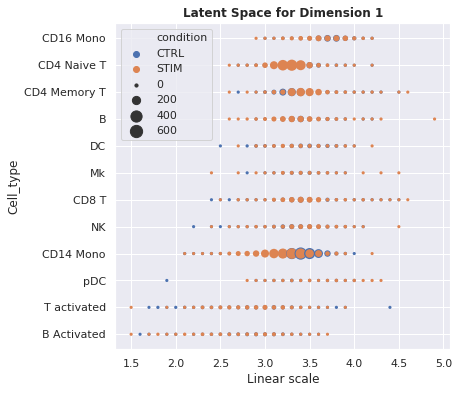

     1dim  groups_dim     cell_type condition
0     NaN        -0.8             B      CTRL
1     NaN        -0.8             B      STIM
2     NaN        -0.8   B Activated      CTRL
3     NaN        -0.8   B Activated      STIM
4     NaN        -0.8  CD4 Memory T      CTRL
..    ...         ...           ...       ...
523   NaN         1.3            NK      STIM
524   NaN         1.3   T activated      CTRL
525   1.0         1.3   T activated      STIM
526   NaN         1.3           pDC      CTRL
527   NaN         1.3           pDC      STIM

[528 rows x 4 columns]


<Figure size 432x288 with 0 Axes>

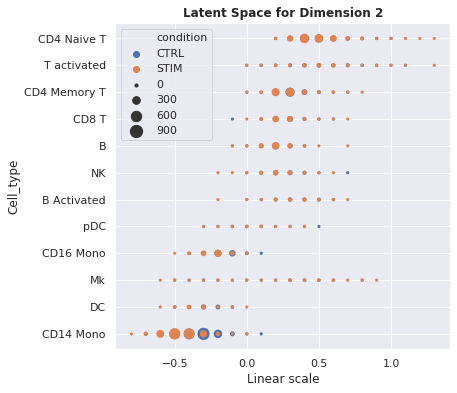

     2dim  groups_dim     cell_type condition
0     NaN         0.4             B      CTRL
1     NaN         0.4             B      STIM
2     NaN         0.4   B Activated      CTRL
3     NaN         0.4   B Activated      STIM
4     NaN         0.4  CD4 Memory T      CTRL
..    ...         ...           ...       ...
739   NaN         3.5            NK      STIM
740   NaN         3.5   T activated      CTRL
741   NaN         3.5   T activated      STIM
742   NaN         3.5           pDC      CTRL
743   NaN         3.5           pDC      STIM

[744 rows x 4 columns]


<Figure size 432x288 with 0 Axes>

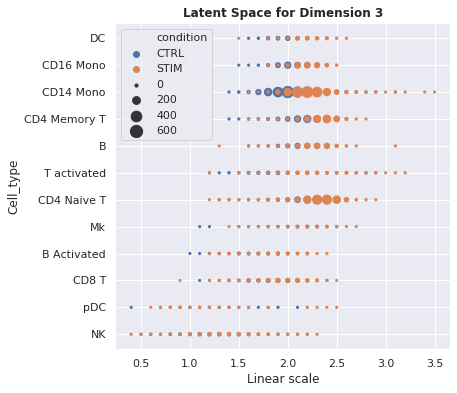

     3dim  groups_dim     cell_type condition
0     NaN        -1.8             B      CTRL
1     NaN        -1.8             B      STIM
2     NaN        -1.8   B Activated      CTRL
3     NaN        -1.8   B Activated      STIM
4     NaN        -1.8  CD4 Memory T      CTRL
..    ...         ...           ...       ...
739   NaN         1.2            NK      STIM
740   NaN         1.2   T activated      CTRL
741   NaN         1.2   T activated      STIM
742   NaN         1.2           pDC      CTRL
743   NaN         1.2           pDC      STIM

[744 rows x 4 columns]


<Figure size 432x288 with 0 Axes>

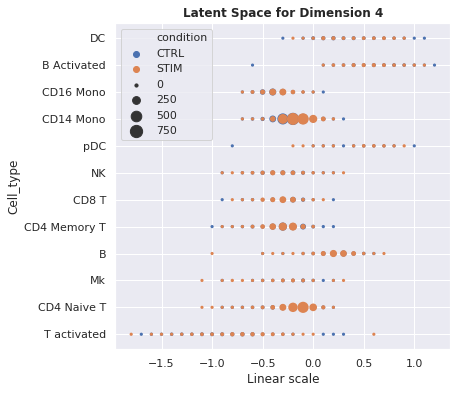

     4dim  groups_dim     cell_type condition
0     NaN        -1.8             B      CTRL
1     NaN        -1.8             B      STIM
2     NaN        -1.8   B Activated      CTRL
3     NaN        -1.8   B Activated      STIM
4     NaN        -1.8  CD4 Memory T      CTRL
..    ...         ...           ...       ...
715   2.0         1.1            NK      STIM
716   NaN         1.1   T activated      CTRL
717   NaN         1.1   T activated      STIM
718   NaN         1.1           pDC      CTRL
719   NaN         1.1           pDC      STIM

[720 rows x 4 columns]


<Figure size 432x288 with 0 Axes>

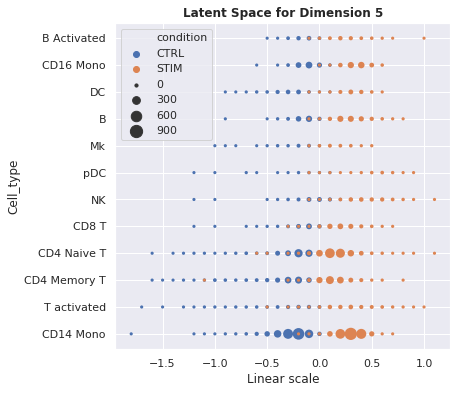

<Figure size 432x288 with 0 Axes>

In [5]:
'''
Creating latent space plots for 2 features: Only for Kang Dataset
Cell Type and Condition together
'''
from latent_space_plots_seurat import *
os.chdir("/storage/groups/ml01/workspace/harshita.agarwala/models_seurat_1000epochs")
path = "latent5_alpha5_c30/"

scg_model = beta_vae_5.C_VAEArithKeras(x_dimension= data.shape[1],z_dimension=5,model_to_use=path,
                                       alpha=5,c_max=30)
scg_model.restore_model()

double_feature_to_latent(path=path,adata=data,feature='cell_type',feature2='condition',
                         model=scg_model,z_dim=5)

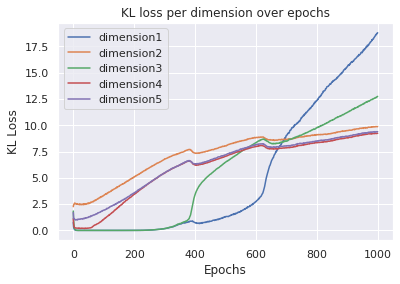

In [6]:
'''
Plot KL Divergence per dimension over epochs
'''
from kl_divergence_plot import *

os.chdir("/storage/groups/ml01/workspace/harshita.agarwala/models_seurat_1000epochs")
path = "latent5_alpha5_c30/"
plot_kl_loss(path=path,z_dim=5)


In [3]:
'''
Simulate one cell in the latent space to view disentanglement between features.
Only for Kang dataset. Disentanglement between 'condition' and 'cell_type'
'''
from simulate_cell import *
os.chdir("/storage/groups/ml01/workspace/harshita.agarwala/models_seurat_1000epochs")
path = "latent5_alpha5_c30/"

scg_model = beta_vae_5.C_VAEArithKeras(x_dimension= data.shape[1],z_dimension=5,model_to_use=path,
                                       alpha=5,c_max=30)
scg_model.restore_model()

#Simulating a random 'B' cell in latent space
simulate_one_cell(path=path,data=data,cell='B',model=scg_model,z_dim=5,feature="cell_type")


<tf.Variable 'Variable:0' shape=() dtype=float32>
Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 14053)             0         
_________________________________________________________________
encoder (Model)              (None, 5)                 11896810  
_________________________________________________________________
decoder (Model)              (None, 14053)             11906853  
Total params: 23,803,663
Trainable params: 23,797,263
Non-trainable params: 6,400
_________________________________________________________________
<tf.Variable 'Variable:0' shape=() dtype=float32>


In [4]:
'''
Finding top 3 marker genes 
'''
sc.tl.rank_genes_groups(data, 'cell_type', method='t-test')
gene_list = [gene for gene in data.uns["rank_genes_groups"]['names']["B"] if not pd.isnull(gene)][:3]
print(gene_list)
sc.tl.rank_genes_groups(data, 'condition', method='t-test')
gene_list = [gene for gene in data.uns["rank_genes_groups"]['names']["CTRL"] if not pd.isnull(gene)][:3]
print(gene_list)
gene_list = [gene for gene in data.uns["rank_genes_groups"]['names']["STIM"] if not pd.isnull(gene)][:3]
print(gene_list)

['CD74', 'RPL18A', 'RPL13A']
['IL8', 'CD14', 'GAPDH']
['ISG15', 'IFI6', 'ISG20']


['B_1.h5ad', 'B_4.h5ad', 'B_0.h5ad', 'B_2.h5ad', 'B_3.h5ad']


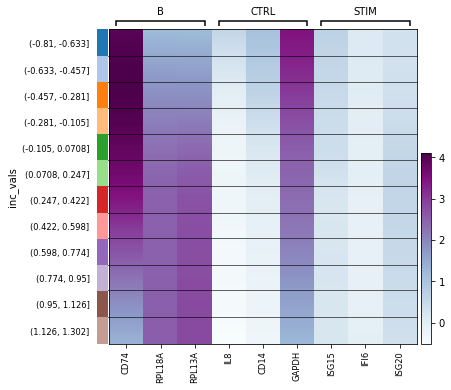

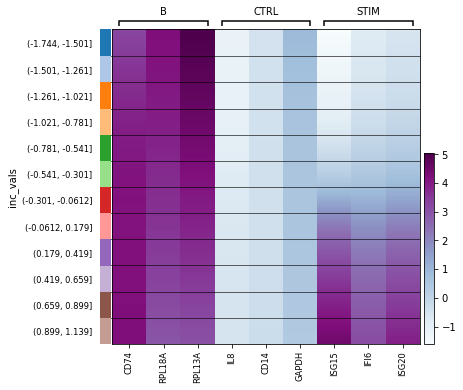

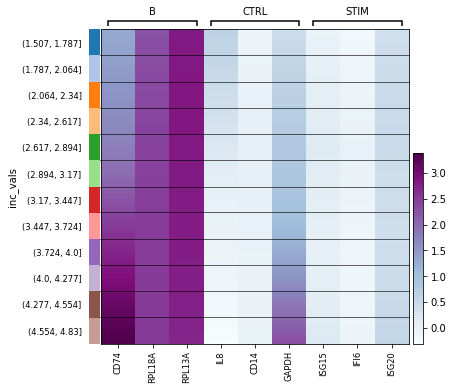

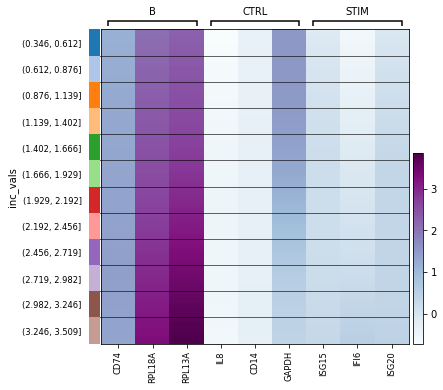

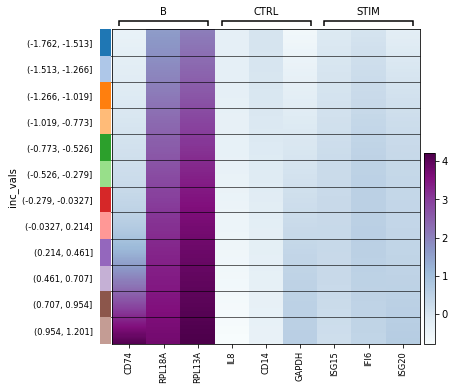

In [11]:
gene_dict = {"B": ['CD74', 'RPL18A', 'RPL13A'],
            "CTRL": ['IL8', 'CD14', 'GAPDH'],
            "STIM":['ISG15', 'IFI6', 'ISG20']}

os.chdir("/storage/groups/ml01/workspace/harshita.agarwala/models_seurat_1000epochs/latent5_alpha5_c30/gene_heatmaps/")
file_list = os.listdir()
print(file_list)
for file in file_list:
    try:
        adata = sc.read(file)
        sc.pl.heatmap(adata,gene_dict, groupby="inc_vals",figsize=(6,6)
                      ,num_categories=12,
                        cmap = "BuPu"
                        ,use_raw=False
                      ,save=file+".png")
    except:
        pass